In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

## Descrption of data

The UTD-MHAD dataset was collected using a Microsoft Kinect sensor and a wearable inertial sensor in an indoor environment. The dataset contains 27 actions performed by 8 subjects (4 females and 4 males). Each subject repeated each action 4 times. After removing three corrupted sequences, the dataset includes 861 data sequences. Four data modalities of RGB videos, depth videos, skeleton joint positions, and the inertial sensor signals were recorded in three channels or threads. One channel was used for simultaneous capture of depth videos and skeleton positions, one channel for RGB videos, and one channel for the inertial sensor signals (3-axis acceleration and 3-axis rotation signals). For data synchronization, a time stamp for each sample was recorded. An example of our multimodality data corresponding to the action basketball-shoot is illustrated in the figure below. For each segmented action trial, the color data was stored in video (.avi) files, and the depth, skeleton and inertial sensor data were stored using the MATLAB computing environment as three .mat files, respectively. As a result, four data files for an action trial are included in the dataset. The naming convention of a file is "ai_sj_tk_modality", where ai stands for action number i, sj stands for subject number j, tk stands for trial k, and modality corresponds to four data modalities (color, depth, skeleton, inertial). A snapshot of the dataset is provided below.

Below are 27 activities. There are 8 subjects (4 males and 4 females) and 4 trials for each recording.
1.  right arm swipe to the left         (swipt_left)
2.  right arm swipe to the right        (swipt_right)
3.  right hand wave                     (wave)
4.  two hand front clap                 (clap) 
5.  right arm throw                     (throw)
6.  cross arms in the chest             (arm_cross)
7.  basketball shooting                 (basketball_shoot)
8.  draw x                              (draw_x)
9.  draw circle  (clockwise)            (draw_circle_CW)
10. draw circle  (counter clockwise)    (draw_circle_CCW)
11. draw triangle                       (draw_triangle)
12. bowling (right hand)                (bowling)
13. front boxing                        (boxing)
14. baseball swing from right           (baseball_swing)
15. tennis forehand swing               (tennis_swing)
16. arm curl (two arms)                 (arm_curl)
17. tennis serve                        (tennis_serve)
18. two hand push                       (push)
19. knock on door                       (knock)
20. hand catch                          (catch)
21. pick up and throw                   (pickup_throw)
22. jogging                             (jog)
23. walking                             (walk)
24. sit to stand                        (sit2stand)
25. stand to sit                        (stand2sit)
26. forward lunge (left foot forward)   (lunge)
27. squat                               (squat)

### The Process of depth data

- Dimension is 240 x 320 x (Number of frames)
- Convert 320 x 240 pixels to flat array
- Create constant columns for 'action', 'subject', 'trial', 'frame'
- Maximum frames = 125

In [2]:
def import_depth_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Depth/a{action}_s{subject}_t{trial}_depth.mat'# The name of the .mat files
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_depth']
    else:
        return None

def transform_depth_data(action, subject, trial):
    rows = []
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        pixels = data[:, :, frame].flatten()
        rows.append(pixels)
    result = np.insert(rows, 0, [[action], [subject], [trial], [frame]], axis=1)
    return np.array(result)

def transform_depth_data_to_df(action, subject, trial):
    data = transform_depth_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame'] + [f'depth_{n}' for n in range(240 * 320)]
    return df

def export_depth_data_to_csv(action, subject, trial):
    df = transform_depth_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_depth.csv'
    df.to_csv(filename, index=False)

def show_depth_image(action, subject, trial, frame):
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    plt.imshow(data[:,:,frame], cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
df_depth = transform_depth_data_to_df(1, 1, 1)

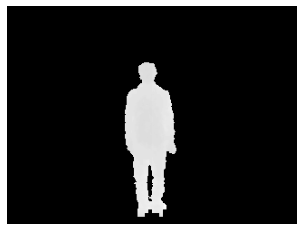

In [4]:
show_depth_image(1, 1, 1, 1)

# Process Inertial Data
- Dimension is (Number of sample) x 6
- The 6 columns: acceleration for x, y, z, x-angular, y-angular, z-angular
- Maximum samples = 326

In [5]:
def import_inertial_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_iner']
    else:
        return None
    
def transform_inertial_data(action, subject, trial):
    data = import_inertial_data(action, subject, trial)
    if data is None: return None
    result = np.insert(data, 0, [[action], [subject], [trial]], axis=1)
    return np.array(result)

def transform_inertial_data_to_df(action, subject, trial):
    data = transform_inertial_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'x-accel', 'y-accel', 'z-accel', 'x-ang-accel', 'y-ang-accel', 'z-ang-accel']
    return df

We can make a genearll raw data set of all records

In [6]:
activities = [i for i in range(1,28)]
raw_dataframe = transform_inertial_data_to_df(0, 0, 0)
for index, action in enumerate(activities):
    for subject in range(1, 9):
        for trial in range(1, 5):
            data = transform_inertial_data_to_df(action, subject, trial) # (160, 6)
            if data is None: continue
            #data = data[0:128] #(128.6) # maximum length is 128
            raw_dataframe = pd.concat([raw_dataframe, data])
raw_dataframe

,action,subject,trial,x-accel,y-accel,z-accel,x-ang-accel,y-ang-accel,z-ang-accel
0,1.0,1.0,1.0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672
1,1.0,1.0,1.0,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275
2,1.0,1.0,1.0,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237
3,1.0,1.0,1.0,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611
4,1.0,1.0,1.0,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412
...,...,...,...,...,...,...,...,...,...
250,27.0,8.0,3.0,-0.908936,0.045410,0.541992,-1.801527,0.427481,0.000000
251,27.0,8.0,3.0,-0.909668,0.055176,0.532471,-2.076336,0.335878,0.244275
252,27.0,8.0,3.0,-0.916748,0.050781,0.528320,-1.954198,0.396947,0.305344
253,27.0,8.0,3.0,-0.915039,0.041260,0.534424,-1.648855,0.244275,0.213740


###  Prcoess

For every trial we put all records in an array to make a vector data as temporally data

In [7]:
activities = [ i for i in range(1,28)]
out_list = []
for index, action in enumerate(activities):
    for subject in range(1, 9):
        for trial in range(1, 5):        
            data_in_matlab = transform_inertial_data_to_df(action, subject, trial) # (160, 6)
            if data_in_matlab is None:
                print('This is jump: ', action, subject, trial )
                continue
            
            # print(data_in_matlab)
            acc_x = np.array(data_in_matlab['x-accel'])[:128]  
            acc_y = np.array(data_in_matlab['y-accel'])[:128]
            acc_z = np.array(data_in_matlab['z-accel'])[:128]
            gyro_x = np.array(data_in_matlab['x-ang-accel'])[:128]
            gyro_y = np.array(data_in_matlab['y-ang-accel'])[:128] 
            gyro_z = np.array(data_in_matlab['z-ang-accel'])[:128]
            
            acc_x = np.pad(acc_x,(0,128 - len(acc_x)),'constant',constant_values = (0))  
            acc_y = np.pad(acc_y,(0,128 - len(acc_y)),'constant',constant_values = (0))  
            acc_z = np.pad(acc_z,(0,128 - len(acc_z)),'constant',constant_values = (0))  
            gyro_x =  np.pad(gyro_x,(0,128 - len(gyro_x)),'constant',constant_values = (0))
            gyro_y =  np.pad( gyro_y,(0,128 - len(gyro_y)),'constant',constant_values = (0)) 
            gyro_z =  np.pad( gyro_z,(0,128 - len( gyro_z)),'constant',constant_values = (0))

            temp_array = np.array([subject, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, action],dtype=object)
            

    
            out_list.append(temp_array)
            #data = data[0:128] #(128.6) # maximum length is 128
            #raw_dataframe = pd.concat([raw_dataframe, data]
            #)

This is jump:  8 1 4
This is jump:  23 6 4
This is jump:  27 8 4


In [8]:
col_label = ['Subject', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','Activity']
# Extract the activities from 1 to 21
sig_data_df = pd.DataFrame(out_list, columns=col_label)
sig_data_df

,Subject,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Activity
0,1,"[-0.959473, -0.961914, -0.974609, -0.941895, -...","[-0.177734, -0.15332, -0.152832, -0.135742, -0...","[-0.192871, -0.159912, -0.145996, -0.12793, -0...","[5.221374, 6.778626, 11.267176, 16.885496, 16....","[1.526718, 1.954198, 3.175573, 4.732824, 4.0, ...","[0.152672, 0.244275, 1.099237, 2.320611, 0.366...",1
1,1,"[-0.967041, -0.990967, -0.987305, -0.991943, -...","[-0.134033, -0.133545, -0.131836, -0.101074, -...","[-0.22583, -0.247803, -0.250732, -0.183838, -0...","[8.244275, 15.694656, 33.557252, 49.160305, 57...","[-3.267176, -0.671756, 2.625954, 4.48855, 8.33...","[2.564885, 3.236641, 3.694656, 3.572519, 5.160...",1
2,1,"[-0.953369, -0.9646, -0.968506, -0.970215, -0....","[-0.146729, -0.147217, -0.139893, -0.137451, -...","[-0.227539, -0.219238, -0.222412, -0.218994, -...","[3.328244, 4.244275, 7.083969, 12.21374, 17.74...","[-1.526718, -1.374046, -0.580153, 0.274809, 1....","[-1.374046, -1.251908, -1.312977, -1.251908, -...",1
3,1,"[-0.953857, -0.961426, -0.991699, -1.025879, -...","[-0.162842, -0.133301, -0.081543, -0.095947, -...","[-0.134033, -0.148926, -0.239014, -0.214844, -...","[7.053435, 13.832061, 28.977099, 56.793893, 86...","[-2.870229, -5.068702, -5.282443, 1.587786, 11...","[-1.19084, -2.320611, -2.564885, -1.801527, -0...",1
4,2,"[-0.998047, -1.037109, -1.083496, -1.129395, -...","[-0.239746, -0.208496, -0.148926, -0.250488, -...","[0.129395, 0.109619, 0.110107, 0.011475, -0.02...","[0.122137, 2.045802, 9.160305, 31.78626, 56.58...","[0.793893, 1.19084, 5.312977, 16.152672, 30.96...","[-0.091603, -1.374046, -4.641221, -8.641221, -...",1
...,...,...,...,...,...,...,...,...
856,7,"[-0.97168, -0.9729, -0.9729, -0.974121, -0.975...","[0.085938, 0.085693, 0.078125, 0.059814, 0.054...","[0.364258, 0.383789, 0.37915, 0.374268, 0.3710...","[11.51145, 11.877863, 13.435115, 14.473282, 11...","[0.366412, -0.824427, -1.221374, -0.916031, 0....","[-4.458015, -5.19084, -5.129771, -4.366412, -3...",27
857,7,"[-0.966064, -0.964111, -0.971924, -0.969971, -...","[0.137207, 0.135986, 0.128662, 0.121338, 0.124...","[0.380859, 0.369141, 0.370361, 0.367676, 0.366...","[-4.396947, -4.641221, -4.580153, -3.877863, -...","[0.946565, 1.038168, 0.610687, 0.335878, 0.549...","[0.030534, -0.091603, -0.244275, -0.305344, -0...",27
858,8,"[-0.914307, -0.915283, -0.913574, -0.915283, -...","[0.040039, 0.030273, 0.038818, 0.03833, 0.0454...","[0.545898, 0.540771, 0.541992, 0.53833, 0.5290...","[-1.618321, -2.076336, -2.198473, -2.748092, -...","[0.427481, 0.48855, 0.977099, 1.038168, 0.6106...","[-1.129771, -1.007634, -0.793893, -0.763359, -...",27
859,8,"[-0.912109, -0.911865, -0.915527, -0.9104, -0....","[0.050537, 0.048584, 0.050781, 0.047852, 0.050...","[0.535889, 0.532471, 0.53833, 0.541748, 0.5312...","[-2.59542, -3.450382, -3.603053, -2.931298, -2...","[0.732824, 0.183206, -0.274809, 0.427481, 1.03...","[-0.519084, -0.396947, -0.427481, -0.854962, -...",27


In [9]:
# Split the data set into train & test set
from sklearn.model_selection import train_test_split
train_UTD, test_UTD = train_test_split(sig_data_df, test_size=0.2, random_state=42)
train_UTD_feature = train_UTD.drop(['Subject','Activity'], axis=1)
train_UTD_label = train_UTD['Activity']
test_UTD_feature = test_UTD.drop(['Subject','Activity'], axis=1)
test_UTD_label = test_UTD['Activity']

In [10]:
train_UTD

,Subject,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Activity
192,1,"[-0.975586, -0.979492, -0.977783, -0.97168, -0...","[-0.29248, -0.287354, -0.283936, -0.289307, -0...","[-0.030273, -0.040771, -0.034668, -0.028564, -...","[-1.740458, -0.946565, 0.274809, 1.587786, 2.1...","[-0.916031, -0.70229, -0.274809, 0.061069, 0.3...","[0.030534, -0.366412, -0.885496, -1.19084, -1....",7
155,7,"[-1.006104, -0.992188, -0.997314, -1.088623, -...","[-0.115967, -0.105225, -0.108643, -0.05249, -0...","[-0.054932, -0.052246, -0.072021, -0.074463, -...","[9.923664, 18.10687, 25.618321, 31.908397, 52....","[0.030534, 0.305344, 0.641221, 2.259542, 9.496...","[2.412214, 3.664122, 4.061069, 3.938931, 2.137...",5
319,1,"[-0.970215, -0.976318, -0.99292, -1.005127, -1...","[-0.449463, -0.444824, -0.481445, -0.604248, -...","[-0.133057, -0.149902, -0.175781, -0.248535, -...","[4.458015, 3.572519, 8.641221, 16.122137, 17.1...","[3.664122, 7.267176, 12.519084, 18.564885, 25....","[-4.458015, -9.19084, -15.603053, -24.549618, ...",11
101,2,"[-1.036377, -1.05249, -1.140869, -1.246338, -1...","[-0.539795, -0.784424, -1.071289, -1.0979, -1....","[0.262451, 0.281982, 0.327148, 0.347412, 0.302...","[12.366412, 6.717557, -25.770992, -54.198473, ...","[34.198473, 51.29771, 66.198473, 78.473282, 82...","[-38.198473, -55.633588, -78.320611, -111.6946...",4
368,5,"[-0.998291, -0.998291, -0.98999, -0.998535, -0...","[-0.090088, -0.08374, -0.0896, -0.087402, -0.0...","[0.272461, 0.27832, 0.270508, 0.26001, 0.26733...","[-4.48855, -4.335878, -3.938931, -4.48855, -3....","[-0.549618, -0.70229, -0.793893, -0.946565, -0...","[1.801527, 1.954198, 1.89313, 2.076336, 2.2900...",12
...,...,...,...,...,...,...,...,...
71,2,"[-0.958984, -0.958252, -1.008301, -1.014404, -...","[-0.185791, -0.17041, -0.152832, -0.171387, -0...","[0.414063, 0.387939, 0.387207, 0.33667, 0.3088...","[5.801527, 6.015267, 11.541985, 24.396947, 43....","[2.870229, 3.908397, 5.129771, 8.48855, 14.534...","[-5.740458, -6.442748, -11.145038, -17.557252,...",3
106,3,"[-0.99707, -0.998535, -1.002686, -0.986328, -0...","[-0.213135, -0.230957, -0.219482, -0.195313, -...","[0.029297, 0.046631, 0.029053, 0.02124, 0.0153...","[-22.076336, -23.78626, -30.80916, -32.549618,...","[2.900763, 2.534351, 2.80916, 3.816794, 5.0076...","[-6.503817, -5.526718, -5.129771, -5.038168, -...",4
270,4,"[-1.005615, -1.000488, -1.001465, -0.998047, -...","[-0.13501, -0.130859, -0.134766, -0.147217, -0...","[0.213379, 0.208008, 0.205322, 0.207764, 0.206...","[-2.045802, -3.480916, -4.305344, -4.946565, -...","[1.679389, 1.801527, 1.801527, 2.10687, 2.1374...","[-0.305344, 0.183206, 0.152672, -0.641221, -0....",9
435,6,"[-1.018799, -1.020264, -1.018799, -1.019775, -...","[-0.174805, -0.195557, -0.230713, -0.269043, -...","[0.020996, 0.016357, -0.010254, -0.049805, -0....","[-4.21374, -2.900763, -3.29771, -5.007634, -7....","[1.679389, 2.381679, 2.992366, 3.175573, 3.053...","[-1.587786, -2.992366, -4.305344, -5.954198, -...",14


In [11]:
train_UTD.dtypes

Subject      int64
acc_x       object
acc_y       object
acc_z       object
gyro_x      object
gyro_y      object
gyro_z      object
Activity     int64
dtype: object

In [12]:
cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']

def build_features(data):
    features = []
    # features = np.empty(shape = (861, 6, 128))
    for i, row in data.iterrows(): 
        # features[i, :, :] = transfer_column(row)
        features.append(transfer_column(row))
    return features    

def transfer_column(row):
    # print((row[col]))
    transfer_row = np.vstack([row[col] for col in cols]) 
    return transfer_row

In [13]:
train_features = build_features(train_UTD)
train_features_utd = np.array(train_features)# list to array # 688, 6, 128
train_labels = train_UTD['Activity'].to_numpy()
train_features_utd_fft = np.abs(np.fft.fft2(train_features_utd))

test_features = build_features(test_UTD)
test_features_utd = np.array(test_features)# list to array # 173, 6, 128
test_labels = test_UTD['Activity'].to_numpy()
test_features_utd_fft = np.abs(np.fft.fft2(test_features_utd))

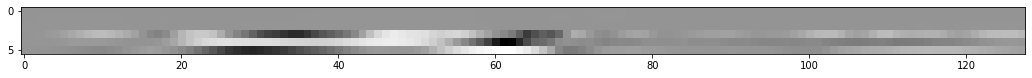

In [14]:
plt.figure(figsize = (18, 7))
plt.imshow(-train_features_utd[100], cmap = 'Greys') # negative so the darker values represent higher numbers.
plt.show()

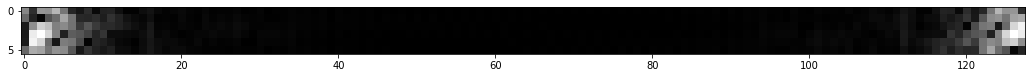

In [15]:
plt.figure(figsize = (18, 7))
plt.imshow(-train_features_utd_fft[100], cmap = 'Greys') # negative so the darker values represent higher numbers.
plt.show()

In [17]:
np.save(f'../Data/UTDMHAD_data/UTD_train_features.npy', train_features_utd)
np.save(f'../Data/UTDMHAD_data/UTD_train_labels.npy', train_labels)
np.save(f'../Data/UTDMHAD_data/UTD_test_features.npy', test_features_utd)
np.save(f'../Data/UTDMHAD_data/UTD_test_labels.npy', test_labels)